# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

from statsmodels.regression.linear_model import OLS
from sklearn.metrics import r2_score, accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def loadPrices(fn):
    global nt, nInst
    df = pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    (nt, nInst) = df.shape
    return (df.values).T

# Load Data

In [4]:
prcAll = loadPrices('prices.txt')

NUM_STOCKS = prcAll.shape[0]

# Build Models

In [5]:
def get_log_returns(prices):
    # get log_returns
    # put into pandas
    prices_df = pd.DataFrame(prices).T
    # turn into log returns
    log_return_df = prices_df.pct_change().apply(lambda x: np.log(1+x)).shift(-1)

    # for ma in [5]:
    #     for stock_i in range(nInst+1):
    #         log_return_df[f'forward_{ma}_{stock_i}'] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma)).shift(-ma)
    #         log_return_df[f'close_to_close (t-{ma})(t0)_'+str(stock_i)] = np.log(prices_df[stock_i]/prices_df[stock_i].shift(ma))
            
    # for ma in [1, 5]:
    #     for stock_i in range(nInst):
    #         for stock_j in range(stock_i+1, nInst):
    #             log_return_df[f'diff_forward_{ma}_{stock_i}_{stock_j}'] = log_return_df[f'forward_{ma}_{stock_i}'] - log_return_df[f'forward_{ma}_{stock_j}']
                # log_return_df[f'diff_close_to_close (t-{ma})(t0)_'+str(stock_i)+'_'+str(stock_j)] = log_return_df[f'close_to_close (t-{ma})(t0)_{stock_i}'] - log_return_df[f'close_to_close (t-{ma})(t0)_{stock_j}']

    return log_return_df

In [6]:
def feature_engineer(prices):
    
    # add market which is the mean of all returns
    prices = np.vstack((prices, prices.mean(axis=0)))

    log_return_df = get_log_returns(prices)
    # feature engineering

    # for stock_id in range(nInst+1):
        # create lags
        # log_return_df['lag1_'+str(stock_id)] = log_return_df[stock_id].shift(1)
        # log_return_df['lag2_'+str(stock_id)] = log_return_df[stock_id].shift(2)
        
        # create MA
        # log_return_df['ma5_'+str(stock_id)] = log_return_df[stock_id].rolling(window=5).mean().shift(1)
        # log_return_df['ma10_'+str(stock_id)] = log_return_df[stock_id].rolling(window=10).mean().shift(1)
        # log_return_df['ma20_'+str(stock_id)] = log_return_df[stock_id].rolling(window=20).mean().shift(1)

    log_return_df.rename(columns={stock_id:str(stock_id) for stock_id in range(nInst+1)}, inplace=True)
        
    
    return log_return_df

In [7]:
log_return_df = feature_engineer(prcAll)

# Backtest

## Define Strategy

In [8]:
def get_CI(log_return_df, test_start_date, train_length, stock_i):

    stock_data = log_return_df[f'{stock_i}']

    stock_data.dropna(inplace=True)

    stock_n = len(stock_data)
    stock_mean = np.nanmean(stock_data)
    stock_std = np.nanstd(stock_data)  

    lower_bound, upper_bound = stock_mean + np.array([-1, 1]) * 2 * stock_std / np.sqrt(stock_n)

    if np.sign(lower_bound) == np.sign(upper_bound):
        return np.sign(lower_bound), True
    else:
        return np.nan, False

def get_recent_CI(log_return_df, test_start_date, train_length, stock_i):

    stock_data = log_return_df[f'{stock_i}'].loc[test_start_date-train_length:test_start_date]

    stock_data.dropna(inplace=True)

    stock_n = len(stock_data)
    stock_mean = np.nanmean(stock_data)
    stock_std = np.nanstd(stock_data)  

    lower_bound, upper_bound = stock_mean + np.array([-1, 1]) * 2 * stock_std / np.sqrt(stock_n)

    if np.sign(lower_bound) == np.sign(upper_bound):
        return np.sign(lower_bound), True
    else:
        return np.nan, False

def get_CI_for_this_period(log_return_df, first_start_date, train_length):

    bull_bear_stocks = dict()

    for stock_i in range(nInst):
        sign, bull_bear_signal = get_CI(log_return_df, first_start_date, train_length, stock_i)
        recent_sign, recent_bull_bear_signal = get_recent_CI(log_return_df, first_start_date, train_length, stock_i)
        
        if bull_bear_signal and recent_bull_bear_signal:
            bull_bear_stocks[stock_i] = sign
        
    
    return bull_bear_stocks

In [9]:
def getMyPosition(prcSoFar):
    
    global currentPos, bull_bear_stocks, old_model_dict, model_features_dict, no_signal, total_signals, first_start_date, replicate_newPos, ban_list
    
    if prcSoFar.shape[1] == START_DATE+250: # last day don't make any new positions
        return currentPos

    log_return_df = feature_engineer(prcSoFar)

    # retrain model every 50 days
    if prcSoFar.shape[1] % TEST_LENGTH == 0:
    
        first_start_date = prcSoFar.shape[1]

        bull_bear_stocks = get_CI_for_this_period(log_return_df, first_start_date, TRAIN_LENGTH)
        
        # make predictions
        for stock_i in bull_bear_stocks:

            if bull_bear_stocks[stock_i] < 0:
                currentPos[stock_i] = -10000/prcSoFar[stock_i, -1]

    return currentPos

## Run

In [10]:
TRAIN_LENGTH = 250
TEST_LENGTH = 250

In [11]:
START_DATE = 250

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
commission_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])
no_signal = 0
total_signals = 0

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(250, 501): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        commission_array[:, prcHistSoFar.shape[1]-START_DATE] = curPrices*np.abs(deltaPos) * commRate

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 250 value: -39.85 todayPL: $-39.85 $-traded: 39849 return: -0.00100
Day 251 value: -109.63 todayPL: $-69.79 $-traded: 39924 return: -0.00275
Day 252 value: -195.81 todayPL: $-86.18 $-traded: 39924 return: -0.00490
Day 253 value: -66.17 todayPL: $129.64 $-traded: 40048 return: -0.00165
Day 254 value: -133.50 todayPL: $-67.32 $-traded: 40172 return: -0.00332
Day 255 value: -150.39 todayPL: $-16.89 $-traded: 40220 return: -0.00374
Day 256 value: -363.42 todayPL: $-213.03 $-traded: 40220 return: -0.00904
Day 257 value: -355.93 todayPL: $7.48 $-traded: 40268 return: -0.00884
Day 258 value: -336.21 todayPL: $19.72 $-traded: 40316 return: -0.00834
Day 259 value: -365.93 todayPL: $-29.72 $-traded: 40316 return: -0.00908
Day 260 value: -379.62 todayPL: $-13.69 $-traded: 40316 return: -0.00942
Day 261 value: -503.55 todayPL: $-123.94 $-traded: 40316 return: -0.01249
Day 262 value: -516.03 todayPL: $-12.48 $-traded: 40316 return: -0.01280
Day 263 value: -458.19 todayPL: $57.84 $-traded: 40316

In [12]:
const = 249
df_rows = []
for STOCK in bull_bear_stocks:

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
# audit_df.to_excel('audit_table_250.xlsx')

In [13]:
bull_bear_stocks

{2: -1.0, 3: -1.0, 27: -1.0, 35: 1.0}

In [14]:
START_DATE = 500

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(500, 751): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

Day 500 value: -29.97 todayPL: $-29.97 $-traded: 29971 return: -0.00100
Day 501 value: -20.10 todayPL: $9.87 $-traded: 30023 return: -0.00067
Day 502 value: 6.38 todayPL: $26.48 $-traded: 30023 return: 0.00021
Day 503 value: 23.03 todayPL: $16.65 $-traded: 30035 return: 0.00077
Day 504 value: 31.28 todayPL: $8.25 $-traded: 30047 return: 0.00104
Day 505 value: 82.57 todayPL: $51.29 $-traded: 30048 return: 0.00275
Day 506 value: 46.01 todayPL: $-36.55 $-traded: 30074 return: 0.00153
Day 507 value: 56.41 todayPL: $10.39 $-traded: 30098 return: 0.00187
Day 508 value: 75.13 todayPL: $18.73 $-traded: 30100 return: 0.00250
Day 509 value: 113.99 todayPL: $38.85 $-traded: 30100 return: 0.00379
Day 510 value: 115.24 todayPL: $1.25 $-traded: 30100 return: 0.00383
Day 511 value: 148.46 todayPL: $33.22 $-traded: 30100 return: 0.00493
Day 512 value: 143.35 todayPL: $-5.11 $-traded: 30100 return: 0.00476
Day 513 value: 133.55 todayPL: $-9.80 $-traded: 30100 return: 0.00444
Day 514 value: 171.61 today

In [15]:
bull_bear_stocks

{18: -1.0, 27: -1.0, 38: -1.0}

In [16]:
const = 249+250
df_rows = []
for STOCK in bull_bear_stocks:

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
# audit_df.to_excel('audit_table_500.xlsx')

In [17]:
START_DATE = 750

signals = np.zeros([50, 251])
positions = np.zeros([50, 251])
returns = np.zeros([50, 251])

values_array = np.zeros([50, 251])
cash_array = np.zeros([50, 251])
todayPL_array = np.zeros([50, 251])

commRate = 0.0010
dlrPosLimit = 10000

nInst = 50
currentPos = np.zeros(nInst)

def calcPL(prcHist):
    global pll
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolumeSignal = 0
    totDVolumeRandom = 0
    value = 0
    todayPLL = []
    (_, nt) = prcHist.shape
    for t in range(750, 1001): # t will go from 250 to 500 (251 numbers)
        prcHistSoFar = prcHist[:, :t] # t=250 => will go from i.e. day 0 to day 249 (250 days). day = t-1; t = 500: don't trade - only lose brockerage
        newPosOrig = getMyPosition(prcHistSoFar) # day 250 train, then make positions for 251...
        curPrices = prcHistSoFar[:, -1]
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.clip(newPosOrig, -posLimits, posLimits) # t0 make new positions
        deltaPos = newPos - curPos # t0 change position
        
        positions[:, prcHistSoFar.shape[1]-START_DATE] = newPos # record position
        
        dvolumes = curPrices * np.abs(deltaPos) # t0 transaction volumes
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume 
        comm = dvolume * commRate # t0 commission
        cash -= curPrices.dot(deltaPos) + comm  # t0 change in cash: long/short stocks and commission

        cash_array[:, prcHistSoFar.shape[1]-START_DATE] = np.zeros([50]) - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate if t == START_DATE \
              else cash_array[:, prcHistSoFar.shape[1]-START_DATE-1] - curPrices * deltaPos - np.abs(deltaPos) * curPrices * commRate

        curPos = np.array(newPos) 
        posValue = curPos.dot(curPrices) # value of stocks = what was earned from t-1's positions + value of t0 stocks. (balances out part of the cash change)
        todayPL = cash + posValue - value # today's profit/loss: cash + value of stocks - value of stocks at t-1 
        
        if t != START_DATE+250:
            returns[:, prcHistSoFar.shape[1]-START_DATE] = prcHist[:, t] / prcHist[:, t-1] - 1
            todayPL_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices if t == START_DATE \
                else cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices - values_array[:, prcHistSoFar.shape[1]-START_DATE-1]

        todayPLL.append(todayPL) 
        value = cash + posValue

        values_array[:, prcHistSoFar.shape[1]-START_DATE] = cash_array[:, prcHistSoFar.shape[1]-START_DATE] + curPos * curPrices

        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
        print("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf" %
              (t, value, todayPL, totDVolume, ret))
    pll = np.array(todayPLL)
    (plmu, plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = np.sqrt(250) * plmu / plstd
    return (plmu, ret, plstd, annSharpe, totDVolume)


(meanpl, ret, plstd, sharpe, dvol) = calcPL(prcAll)
score = meanpl - 0.1*plstd
print("=====")
print("mean(PL): %.1lf" % meanpl)
print("return: %.5lf" % ret)
print("StdDev(PL): %.2lf" % plstd)
print("annSharpe(PL): %.2lf " % sharpe)
print("totDvolume: %.0lf " % dvol)
print("Score: %.2lf" % score)

IndexError: index 750 is out of bounds for axis 1 with size 750

In [ ]:
const = 249+500

df_rows = []
for STOCK in bull_bear_stocks:

    for i in range(251):
        df_rows.append({
            'Signal': int(np.sign(signals[STOCK][i])),
            'Price': prcAll[STOCK][i+const],
            'Price x Positions': prcAll[STOCK][i+const] * positions[STOCK][i],
            'Change in positions': np.round(positions[STOCK][i]-positions[STOCK][i-1], 1) if i != 0 else np.round(positions[STOCK][i], 1),
            'Positions': np.round(positions[STOCK][i], 1),
            'PnL': np.round(todayPL_array[STOCK][i], 2),
            'PnL + Commission': np.round(todayPL_array[STOCK][i]+commission_array[STOCK][i], 2),
            'Returns': np.round(returns[STOCK][i], 4),
            'Commission': np.round(commission_array[STOCK][i], 2),
            'Stock': STOCK,
            'Day': i+const+1})
            # 'audit_PnL': returns[STOCK][i] * positions[STOCK][i] * prcAll[STOCK][i+249]})

audit_df = pd.DataFrame(df_rows)
# audit_df.to_excel('audit_table_750.xlsx')

In [ ]:
bull_bear_stocks

{1: -1.0,
 3: -1.0,
 10: -1.0,
 12: -1.0,
 13: -1.0,
 14: -1.0,
 19: -1.0,
 20: -1.0,
 34: -1.0,
 37: -1.0,
 38: -1.0,
 44: -1.0}

# Evaluation

In [ ]:
# returns_flatten = returns[:250].flatten()
# signals_flatten = signals[:250].flatten()

# buckets = {}
# for i in range(-51, 51, 5):
#     buckets[(i, i+1)] = [returns_flatten[j] for j in range(len(returns_flatten)) if signals_flatten[j] >= i and signals_flatten[j] < i+1]
# buckets = [(key, np.mean(value)) for key, value in buckets.items()]

# # Extract the mid-point of each bucket range and the mean returns
# bucket_midpoints = [(key[0] + key[1]) / 2 for key, value in buckets]
# bucket_means = [value for key, value in buckets]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.scatter(bucket_midpoints, bucket_means, color='blue')
# plt.xlabel('Signal Buckets Midpoints')
# plt.ylabel('Mean Returns')
# plt.axvline(x=0, color='r', linestyle='-')
# plt.axhline(y=0, color='r', linestyle='-')
# plt.title('Mean Returns per Signal Bucket')
# plt.grid(True)
# plt.show()

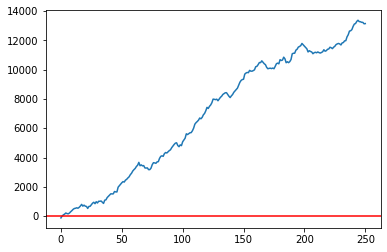

In [ ]:
plt.plot(np.cumsum(pll))
plt.axhline(y=0, color='r', linestyle='-')

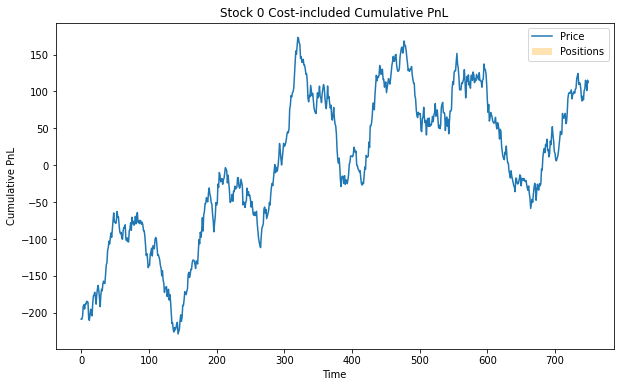

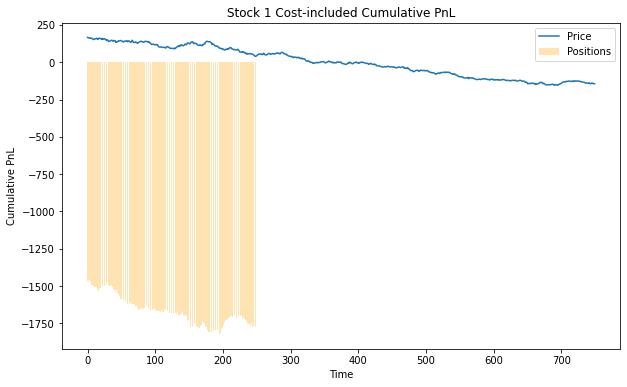

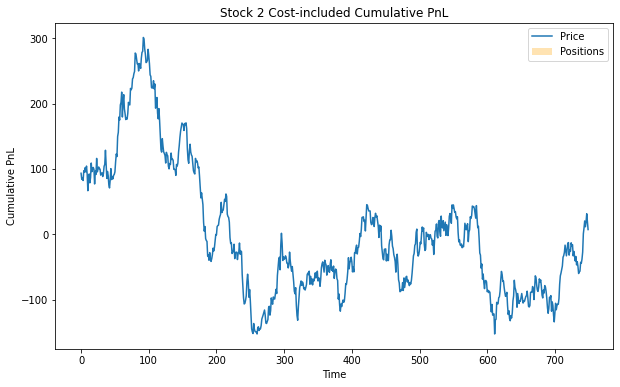

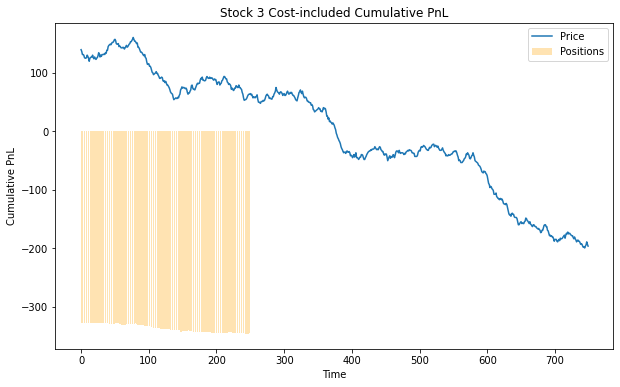

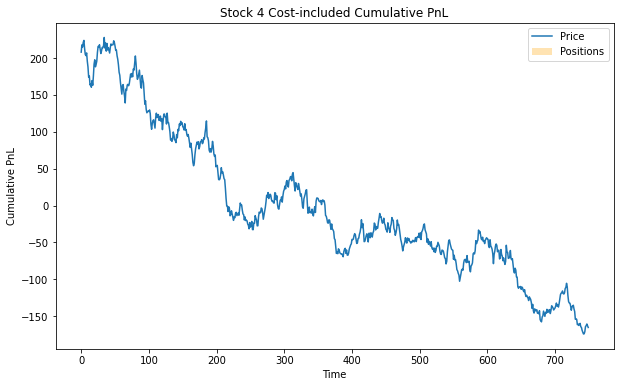

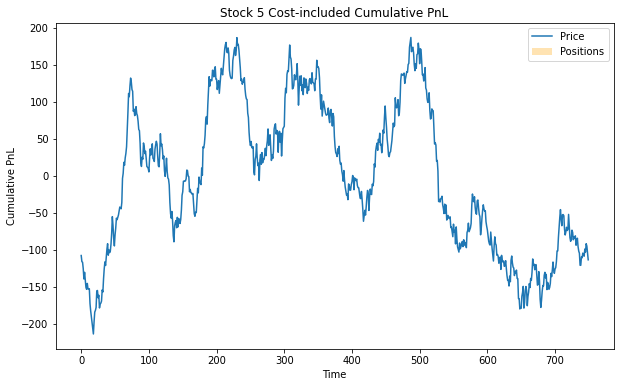

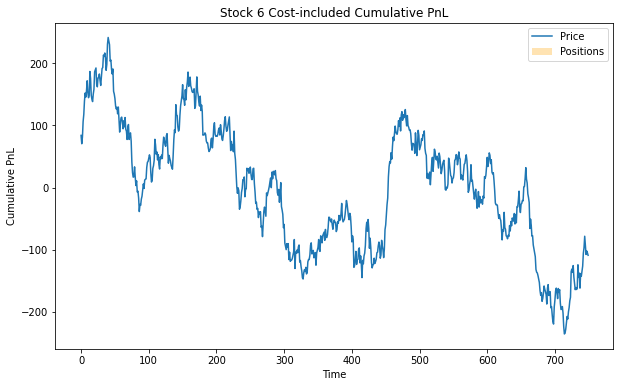

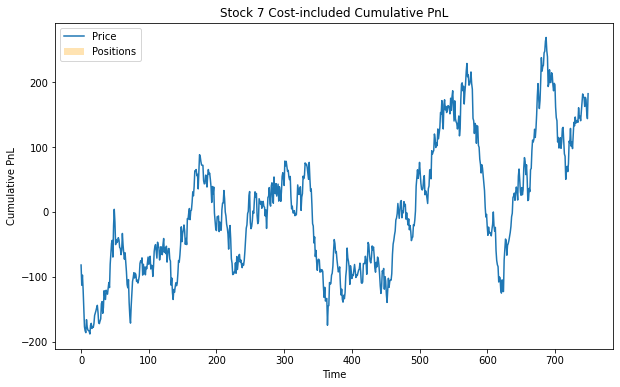

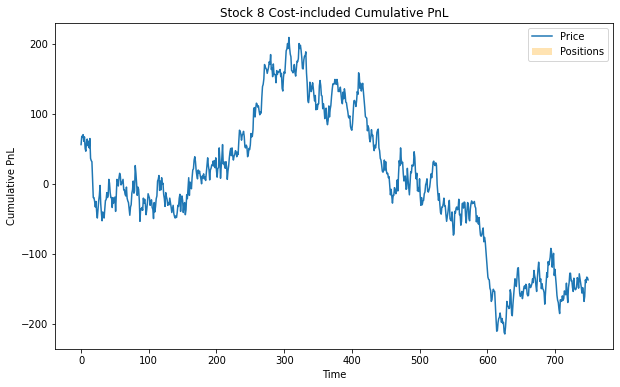

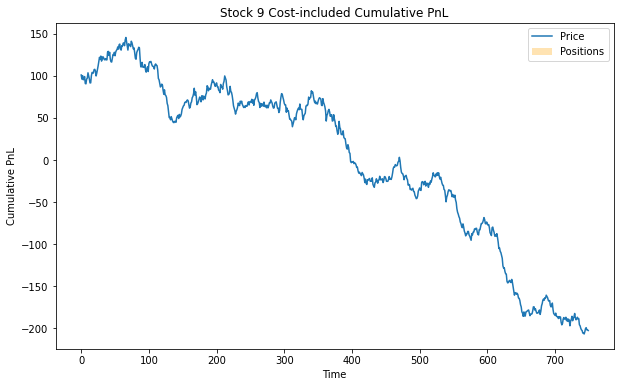

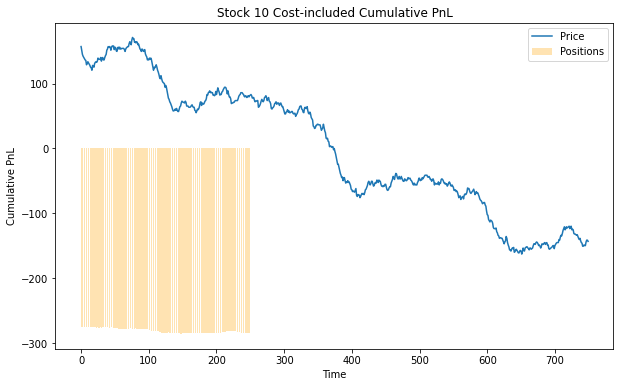

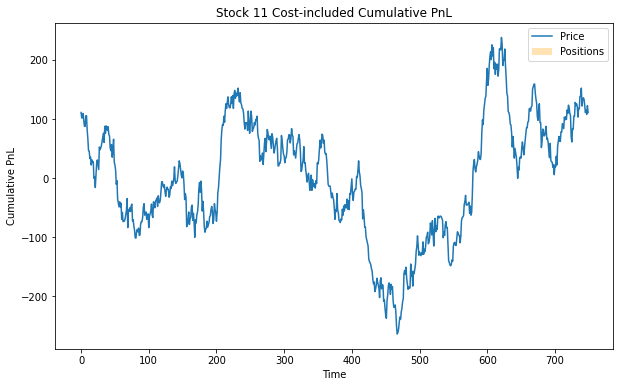

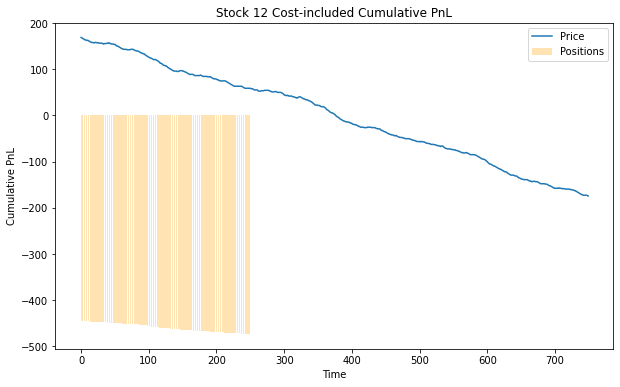

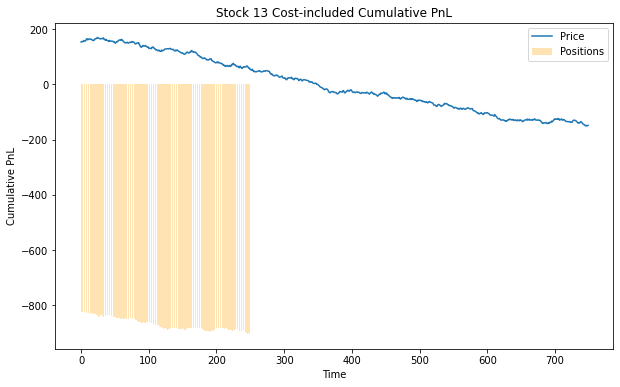

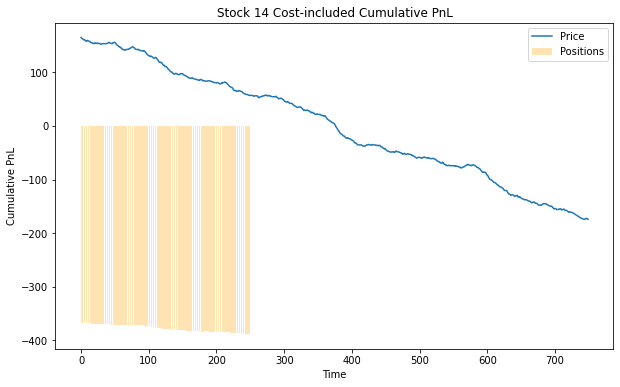

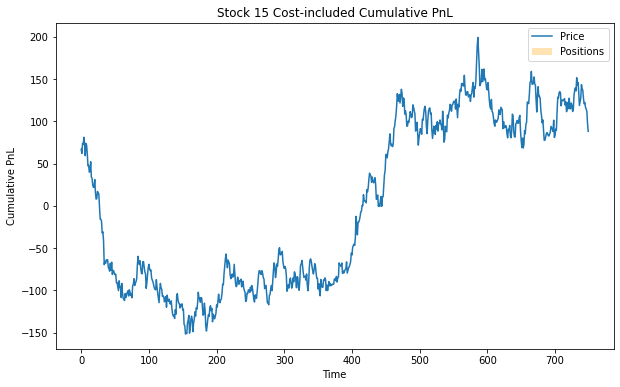

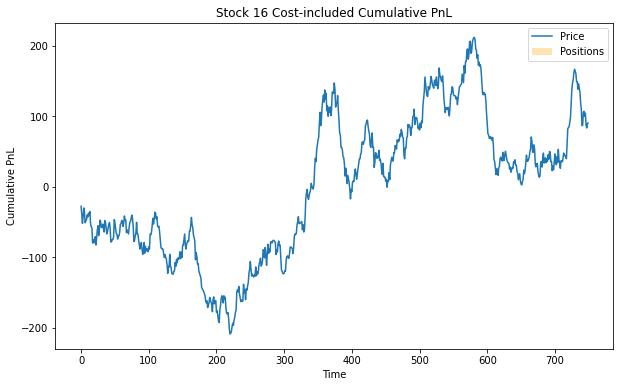

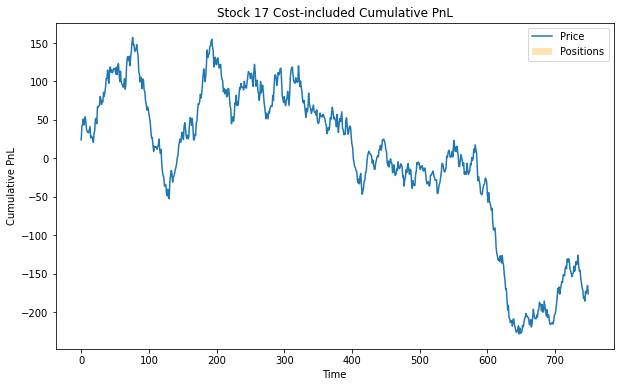

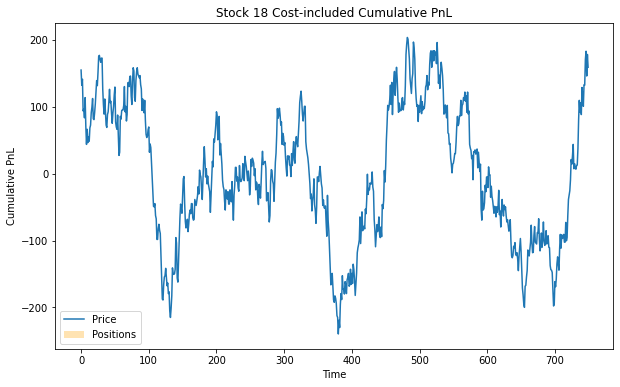

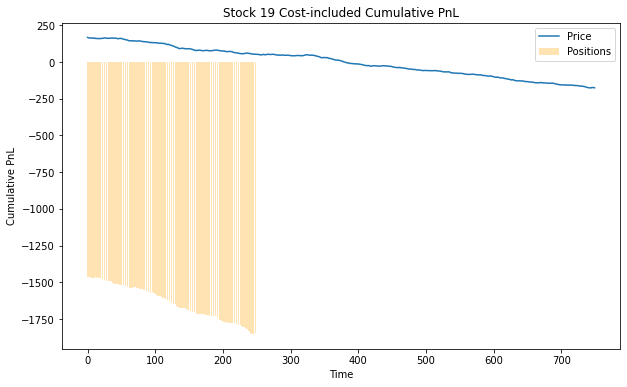

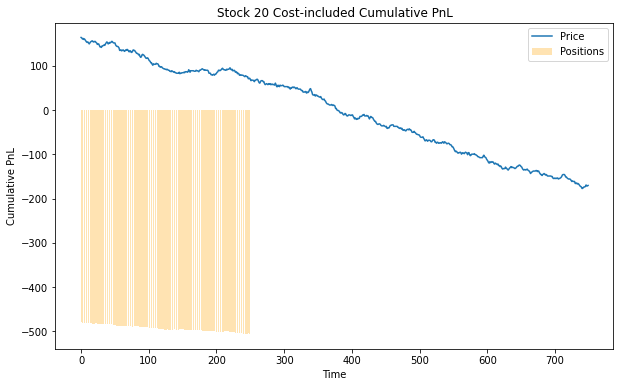

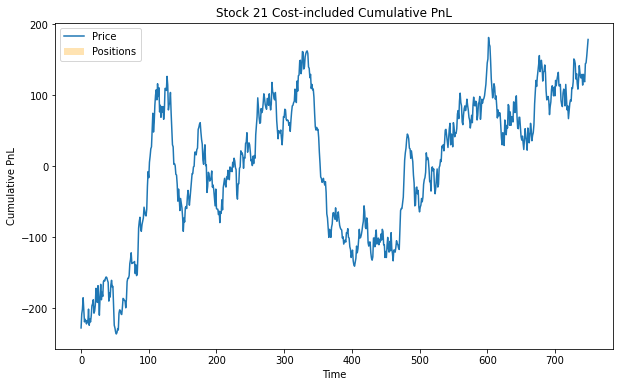

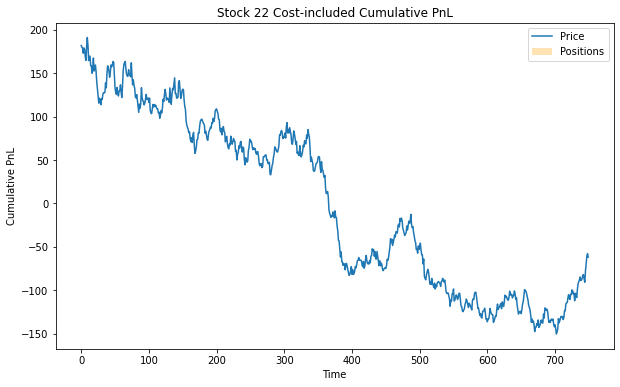

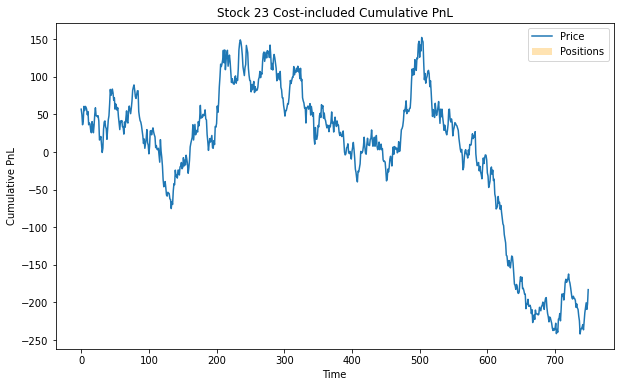

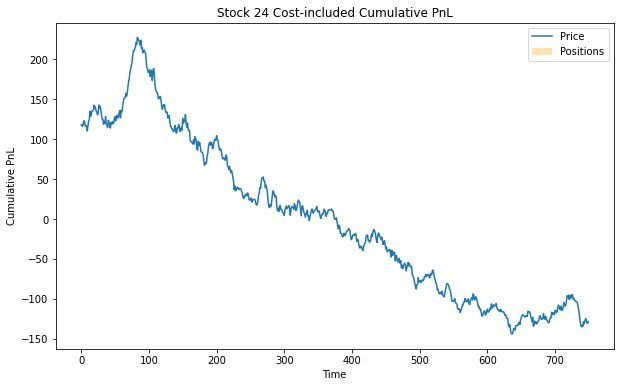

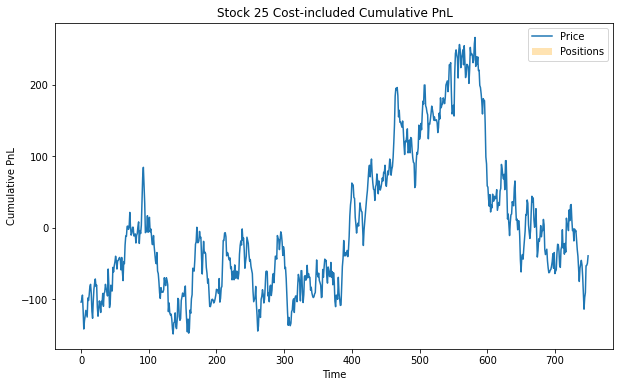

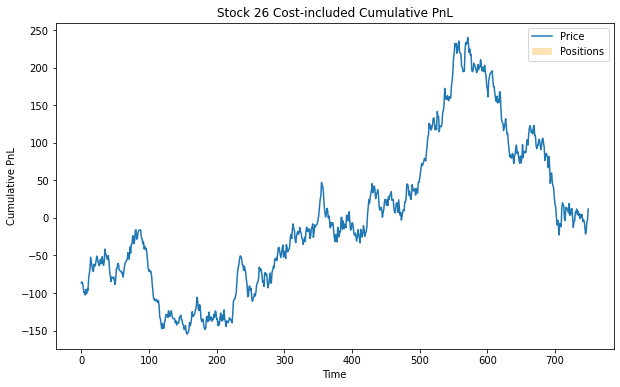

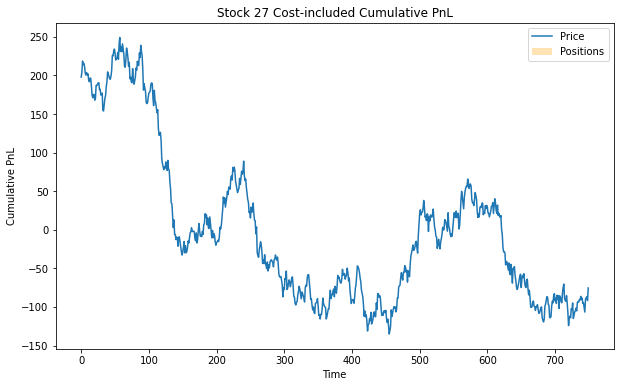

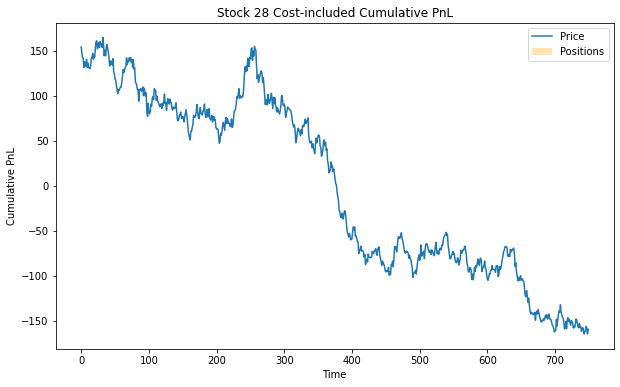

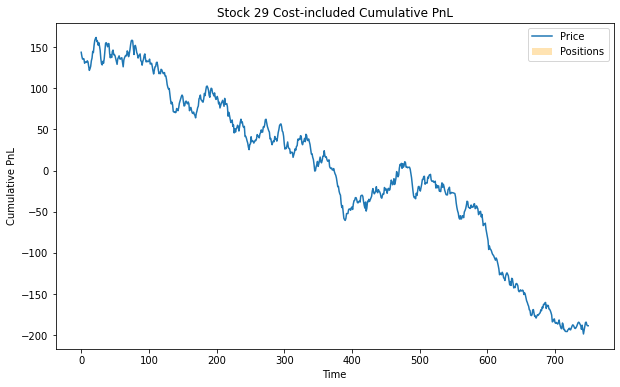

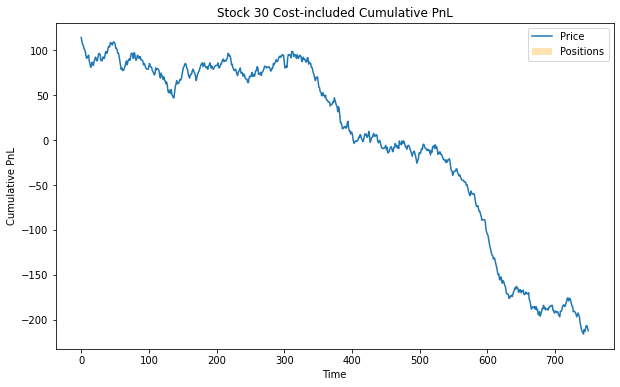

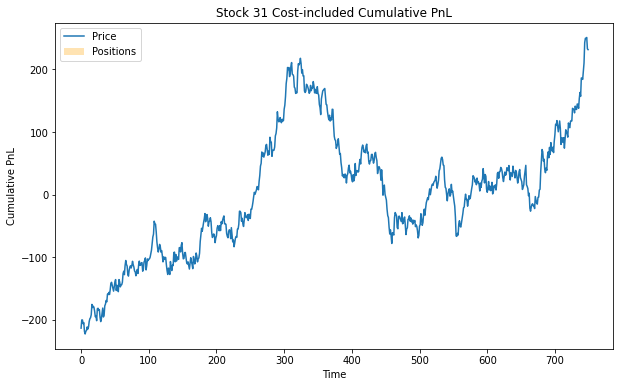

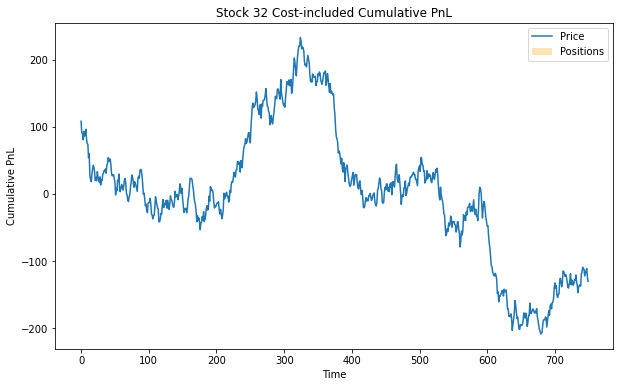

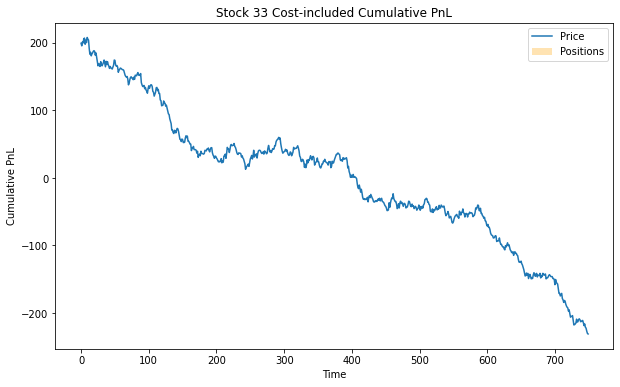

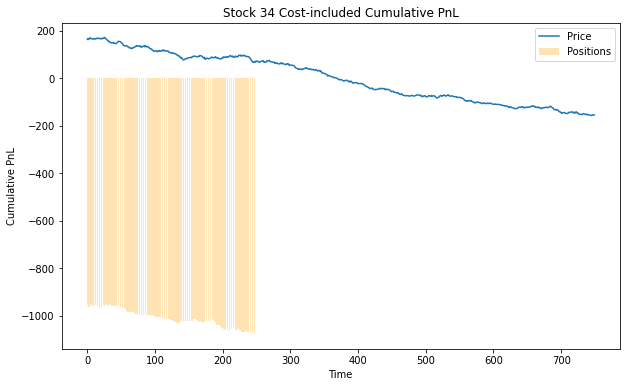

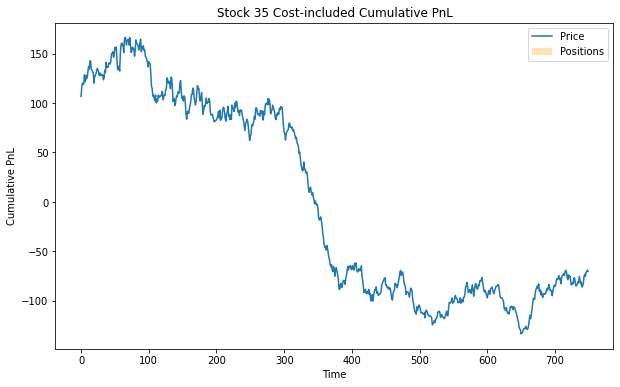

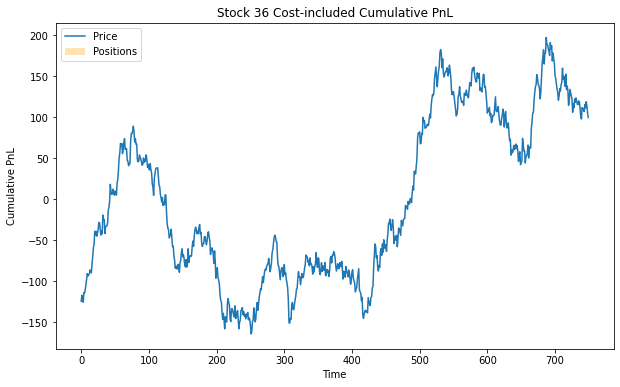

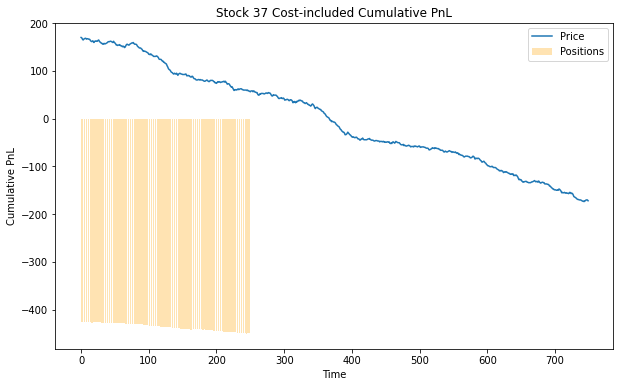

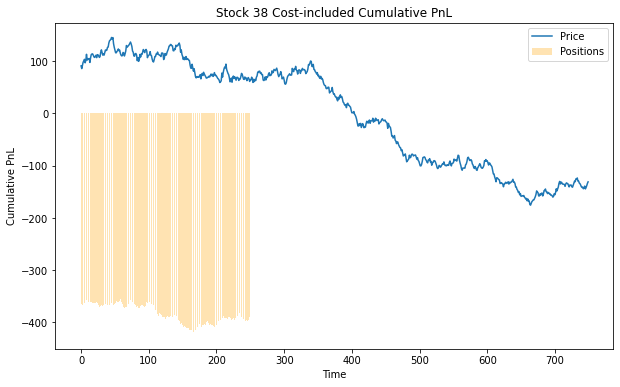

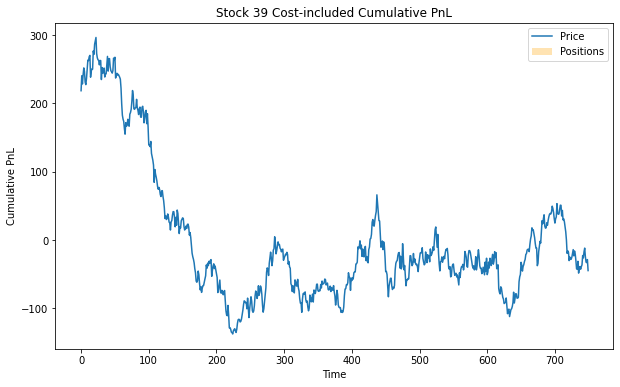

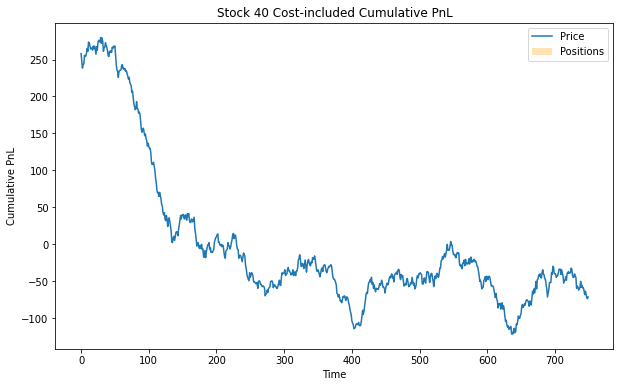

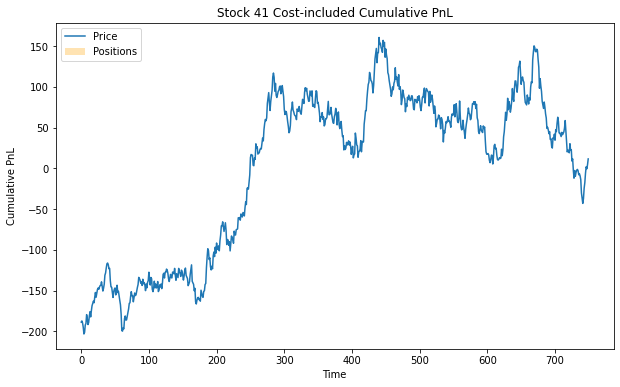

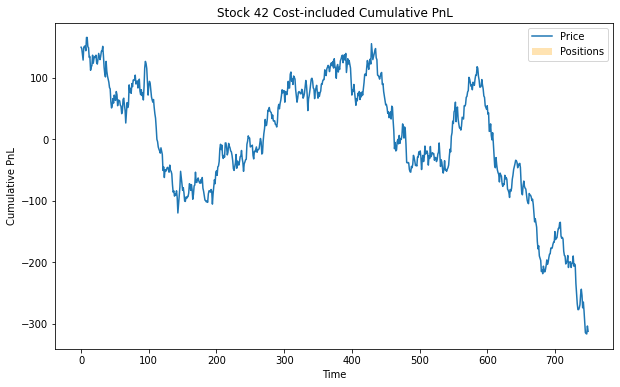

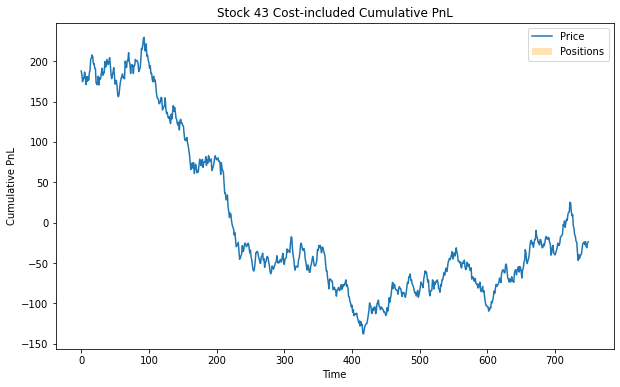

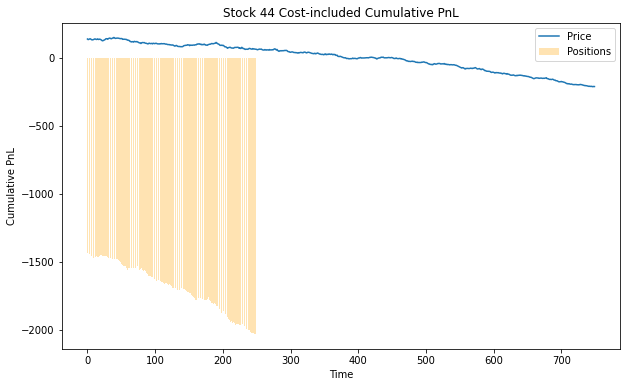

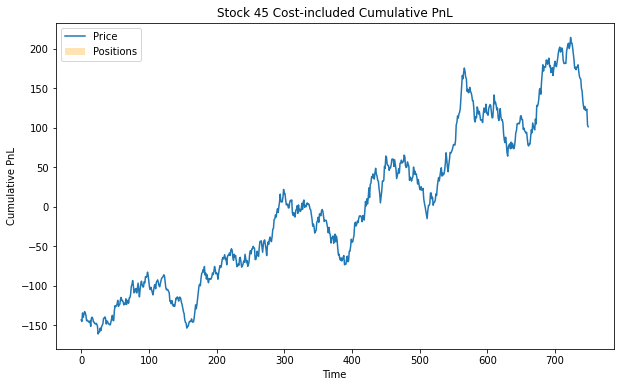

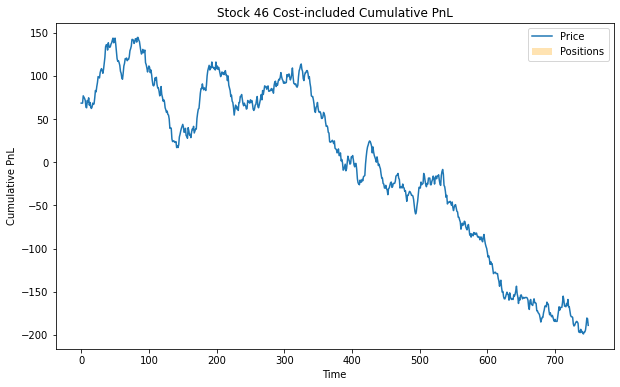

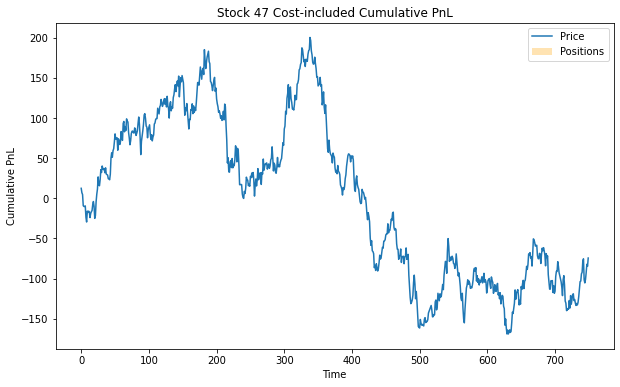

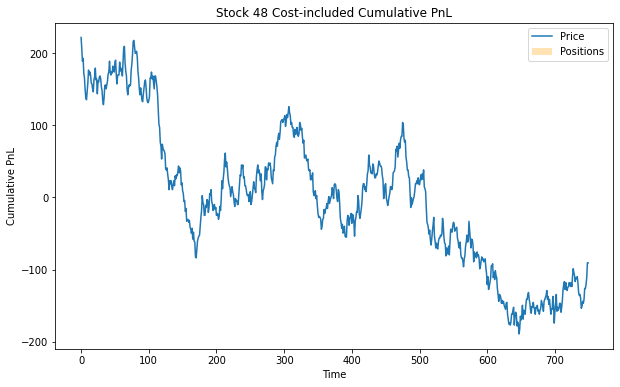

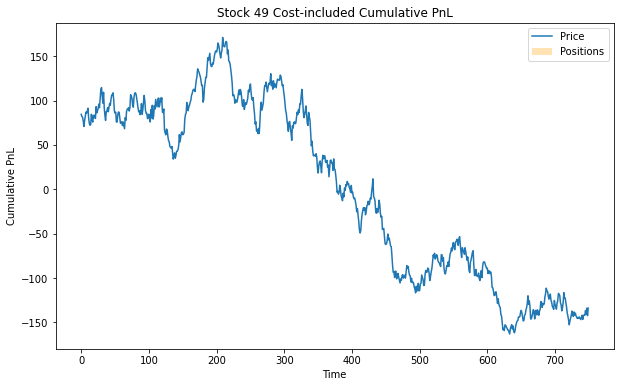

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming todayPL_array and positions are already defined and have appropriate shapes.

for i in range(50):
    plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
    # Plot the cumulative PnL
    plt.plot(100*(prcAll[i, 250:] - np.mean(prcAll[i, 250:]))/np.std(prcAll[i, 250:]), label='Price')
    
    # Add the bar chart at y = 0
    plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
    # Adding a title and labels
    plt.title(f'Stock {i} Cost-included Cumulative PnL')
    plt.xlabel('Time')
    plt.ylabel('Cumulative PnL')
    
    # Adding a legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming todayPL_array and positions are already defined and have appropriate shapes.

# for i in range(50):
#     plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
    
#     # Plot the cumulative PnL
#     plt.plot(np.cumsum(todayPL_array[i, :250]), label='Cumulative PnL')
    
#     # Add the bar chart at y = 0
#     plt.bar(range(250), positions[i, :250], alpha=0.3, label='Positions', color='orange')
    
#     # Adding a title and labels
#     plt.title(f'Stock {i} Cost-included Cumulative PnL')
#     plt.xlabel('Time')
#     plt.ylabel('Cumulative PnL')
    
#     # Adding a legend
#     plt.legend()
    
#     # Show the plot
#     plt.show()
